In [97]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import sys
sys.path.append("../scripts/twitter")
from searchTwitter import TwitterDataFrame
import utils as ut

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor


In [39]:
def concat_data(base_dir):
    files = os.listdir(base_dir)
    dfs = []
    for f in files:
        dfs.append(pd.read_csv(base_dir + f))
        
    return pd.concat(dfs)

health_df = concat_data('../data/san_francisco/')
health_df.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_8920/1872091701.py:5: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(base_dir + f))


,id,author_id,text,geo,created_at,lat,lon
0,968999128641323008,25624940,@Volker_E Am I hallucinating that you are walk...,{'place_id': '5a110d312052166f'},2018-02-28 23:59:30,37.708075,-122.514926
1,968999100757680128,8888,There’s just something weird about living in N...,{'place_id': '5ef5b7f391e30aff'},2018-02-28 23:59:23,37.845953,-122.324818
2,968999065273774080,1557223812,Tomorrow’s March sheeeesh I’m basically 24 😕 t...,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:14,37.592632,-122.160814
3,968999056537088000,1164993320,Wednesday really be draining 6-6 school day 😴,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:12,37.592632,-122.160814
4,968999038493245440,18650764,@remedy415 @Brycesavoy510 This hella dope,{'place_id': 'ab2f2fac83aa388d'},2018-02-28 23:59:08,37.699279,-122.342660


In [69]:
# Turn into a TwitterDataFrame and zoom in on san francisco
health_df = TwitterDataFrame(health_df)
lat = (37, 39)
lon = (-121, -124)
sf_df_raw = health_df.zoom_in(lat, lon)

In [70]:
# Take a random subsample of the dataframe to reduce the size
sf_df_raw = sf_df_raw.sample(32000, replace=True)

# Ideally this should be before sampling but this way saves time
# Could this happen in TwitterDataFrame?
sf_df_raw['created_at'] = [datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in sf_df_raw['created_at']]

# Subset 5/2018-12/2018
sf_df_raw = sf_df_raw[sf_df_raw['created_at'] > datetime(2018, 4, 30)]

# Change date quantum to day
sf_df_raw['date'] = sf_df_raw['created_at'].dt.floor('d')

sf_df = TwitterDataFrame(sf_df_raw)
sf_df.head()

,id,author_id,text,geo,created_at,lat,lon,date
18754,1023419764436217857,3457330753,@drtonyevans You’re welcome Dr Evans and will ...,{'place_id': 'ab2f2fac83aa388d'},2018-07-29 04:07:40,37.699279,-122.342660,2018-07-29
200880,1014407260351561729,33294102,@zedd always killin’ visuals 😮😍,{'place_id': '5ecbd073f39c00fa'},2018-07-04 07:15:12,37.592632,-122.160814,2018-07-04
34789,1056027622310727680,389830080,@Drake can I shoot the halfcourt shot?,{'place_id': 'ab2f2fac83aa388d'},2018-10-27 03:39:39,37.699279,-122.342660,2018-10-27
119969,1051874864141754368,543147905,Do you still get asked if you're 15 and can si...,{'place_id': '5a110d312052166f'},2018-10-15 16:38:05,37.708075,-122.514926,2018-10-15
92599,1019735783383560192,923027185568399360,@dailyunnie @BTS_twt Thanks for sharing this. ...,{'place_id': 'ab2f2fac83aa388d'},2018-07-19 00:08:51,37.699279,-122.342660,2018-07-19


In [72]:
# What are the basics of this data set?
print("Lenth: ", len(sf_df))
print("Per day :", len(sf_df)/365)

Lenth:  25669
Per day : 70.32602739726028


Text(0.5, 0, 'Date')

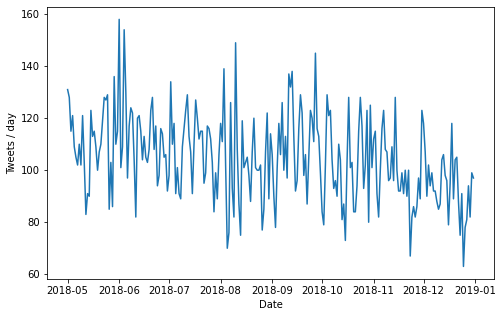

In [73]:
# Plot num tweets per day by date
plt.figure(figsize=(8,5))
plt.plot(sf_df.count_by_day())
ax = plt.gca()
ax.set_ylabel("Tweets / day")
ax.set_xlabel("Date")

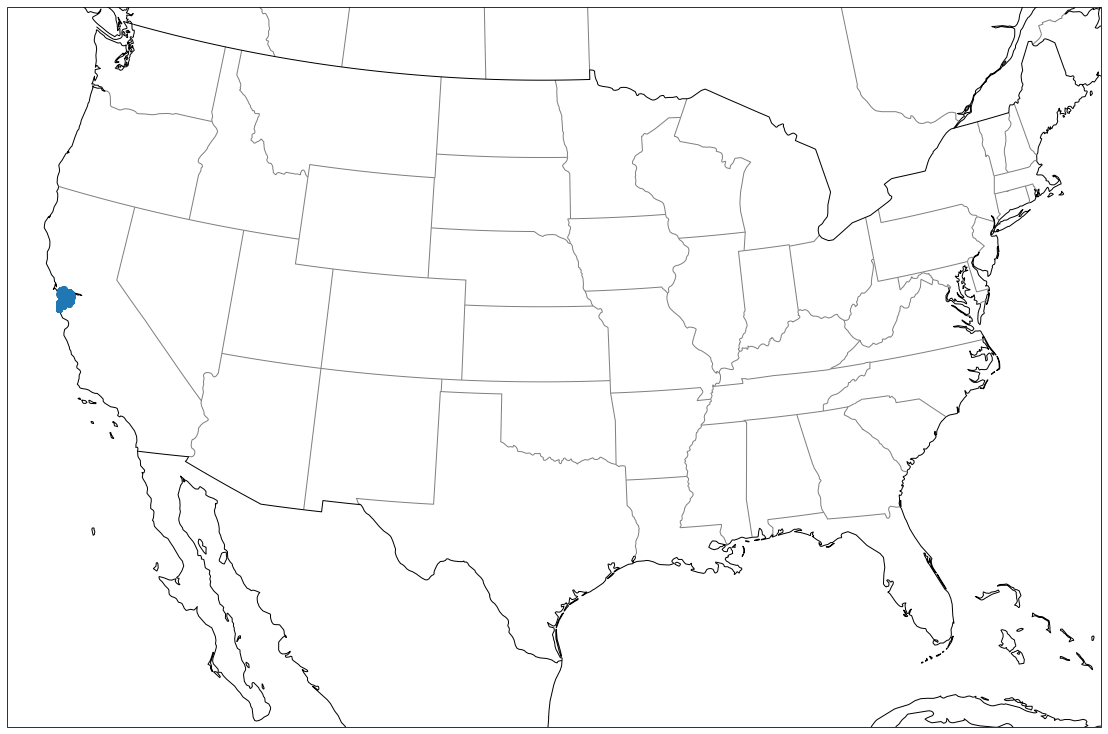

In [74]:
import cartopy
import cartopy.feature as cfeature
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0, 0, 1, 1], projection=cartopy.crs.LambertConformal(central_longitude=-98.0))
ax.set_extent((-120, -75,21, 50), cartopy.crs.Geodetic())
ax.coastlines()

# Add state boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS)
ax.scatter(sf_df['lon'],sf_df['lat'], transform=cartopy.crs.PlateCarree())
# plt.show()

In [75]:
aqi_2018 = pd.read_csv('../data/daily_aqi_by_county_2018.csv')
sf_aqi = aqi_2018[(aqi_2018['State Name']=='California') & (aqi_2018['county Name']=='San Francisco')]
sf_aqi['Date'] = pd.to_datetime(sf_aqi['Date'])

sf_aqi.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_8920/3088310655.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sf_aqi['Date'] = pd.to_datetime(sf_aqi['Date'])


,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
27443,California,San Francisco,6,75,2018-01-01,72,Moderate,PM2.5,06-075-0005,1
27444,California,San Francisco,6,75,2018-01-02,82,Moderate,PM2.5,06-075-0005,1
27445,California,San Francisco,6,75,2018-01-03,111,Unhealthy for Sensitive Groups,PM2.5,06-075-0005,1
27446,California,San Francisco,6,75,2018-01-04,58,Moderate,PM2.5,06-075-0005,1
27447,California,San Francisco,6,75,2018-01-05,26,Good,NO2,06-075-0005,1


In [100]:
sf_mrg = pd.merge(left=sf_df, right=sf_aqi, left_on='date', right_on='Date', how='inner')

X = sf_mrg['text']
y = sf_mrg['AQI'] / max(sf_mrg['AQI']) # standardize

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=23)

sf_mrg.head()

,id,author_id,text,geo,created_at,lat,lon,date,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,1023419764436217857,3457330753,@drtonyevans You’re welcome Dr Evans and will ...,{'place_id': 'ab2f2fac83aa388d'},2018-07-29 04:07:40,37.699279,-122.342660,2018-07-29,California,San Francisco,6,75,2018-07-29,19,Good,Ozone,06-075-0005,1
1,1023644271566413824,719983288681500672,@_Music_Is_Lyfe @urkle9 @GuapoSlum That's all ...,{'place_id': 'ab2f2fac83aa388d'},2018-07-29 18:59:47,37.699279,-122.342660,2018-07-29,California,San Francisco,6,75,2018-07-29,19,Good,Ozone,06-075-0005,1
2,1023617783093817345,892277768,#ThrustFoundation Get BEHIND it!,{'place_id': '00b2a7b60c2a6879'},2018-07-29 17:14:32,37.872039,-122.507602,2018-07-29,California,San Francisco,6,75,2018-07-29,19,Good,Ozone,06-075-0005,1
3,1023682963240701952,2456866736,@WoJCC @TrueGeordieTG Why is he not commentati...,{'place_id': '5a110d312052166f'},2018-07-29 21:33:32,37.708075,-122.514926,2018-07-29,California,San Francisco,6,75,2018-07-29,19,Good,Ozone,06-075-0005,1
4,1023615274262573056,12514,The hypocrisy of all this is absolutely sicken...,{'place_id': '5a110d312052166f'},2018-07-29 17:04:33,37.708075,-122.514926,2018-07-29,California,San Francisco,6,75,2018-07-29,19,Good,Ozone,06-075-0005,1


In [101]:
X_train.shape, y_train.shape

((20535,), (20535,))

In [102]:
# Vectorize data
tf_vect = TfidfVectorizer(min_df=1, stop_words="english")
X_enc = tf_vect.fit_transform(X_train)

# Run trunvated SVD on the vector encodings
svd = TruncatedSVD(n_components=100)
X_lsa = svd.fit_transform(X_enc)

X_lsa.shape

(20535, 100)

Text(0.5, 1.0, 'First Two Dimensions of SVD Encoding')

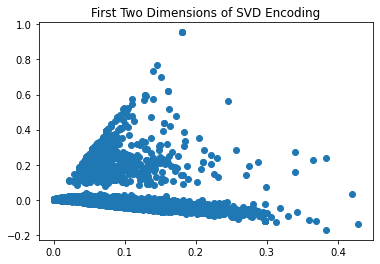

In [103]:
# Scatter the results
plt.scatter(X_lsa[:, 0], X_lsa[:, 1])
plt.title("First Two Dimensions of SVD Encoding")

Text(0.5, 1.0, 'Standardized AQI by Low Dimension Tweets')

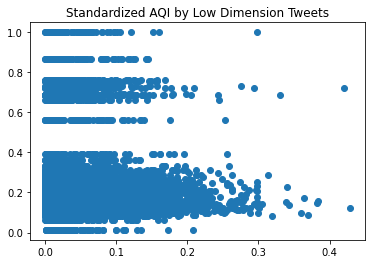

In [104]:
# Scatter the results
plt.scatter(X_lsa[:, 0], y_train)
plt.title("Standardized AQI by Low Dimension Tweets")

In [108]:
model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_lsa, y_train)

model.score(X_lsa, y_train)

0.09965549310290933